Here we recreate the sample visualisations seen in figure 1 (method overview) from the PBMC datasets.

In [1]:
import sys
sys.path.append('../src/')

import config
import logging
import numpy as np
import scanpy as sc
import pandas as pd
from refcm import RefCM
import matplotlib.pyplot as plt

config.start_logging(logging.DEBUG)

In [3]:
# load the datasets
q = sc.read_h5ad('../data/pbmc_Drop-Seq.h5ad') 
ref = sc.read_h5ad('../data/pbmc_CEL-Seq.h5ad') 

[h5py._conv      ] [DEBUG   ] : Creating converter from 3 to 5


In [4]:
# labels available in each
q.obs['labels'].unique().tolist(), ref.obs['labels'].unique().tolist()

(['CD4+ T cell',
  'Cytotoxic T cell',
  'Natural killer cell',
  'CD14+ monocyte',
  'CD16+ monocyte',
  'B cell',
  'Dendritic cell',
  'Megakaryocyte',
  'Plasmacytoid dendritic cell'],
 ['CD4+ T cell',
  'Cytotoxic T cell',
  'Natural killer cell',
  'CD16+ monocyte',
  'CD14+ monocyte',
  'Megakaryocyte',
  'B cell'])

In [4]:
# we will merge reference T cells as example of a coarser annotation level
ref.obs['labels'] = ref.obs['labels'].astype('str')
t_mask = ref.obs.labels.isin(['CD4+ T cell', 'Cytotoxic T cell'])
ref.obs.loc[t_mask, 'labels'] = 'T cell'

# keep only select query & reference cell types/clusters for simplicity
q_mask = q.obs.labels.isin(['Megakaryocyte', 'CD4+ T cell', 'Cytotoxic T cell', 'Natural killer cell'])
ref_mask = ref.obs.labels.isin(['B cell', 'T cell', 'Natural killer cell'])
 
q = q[q_mask]
ref = ref[ref_mask]

In [7]:
rcm = RefCM(cache_load=False, cache_save=False, max_merges=2)
m = rcm.annotate(q, 'pbmc_Drop-Seq', ref, 'pbmc_CEL-Seq', 'labels', 'labels')

# slightly lower type equality strictness for display, since "CD4+ T cell" is a subset of "T cells"
m.set_type_equality_strictness(0.7)

# evaluate, and display costs with results
m.display_matching_costs('labels')

[refcm           ] [INFO    ] : NOTE: raw counts expected in anndata .X attributes.
[refcm           ] [DEBUG   ] : No existing cost-cache found (../src/cache.json).
[embeddings      ] [DEBUG   ] : Using 1478 genes.
[refcm           ] [DEBUG   ] : Computing Wasserstein distances.
|████████████████| [100.00% ] : 00:30
[refcm           ] [DEBUG   ] : starting LP optimization
[refcm           ] [DEBUG   ] : optimization terminated w. status "Optimal"
[matchings       ] [INFO    ] : Type strictness updated: 1.00 -> 0.70


For better data visualisation, we can plot the query and reference data, as well as their embeddings

... storing 'query' as categorical


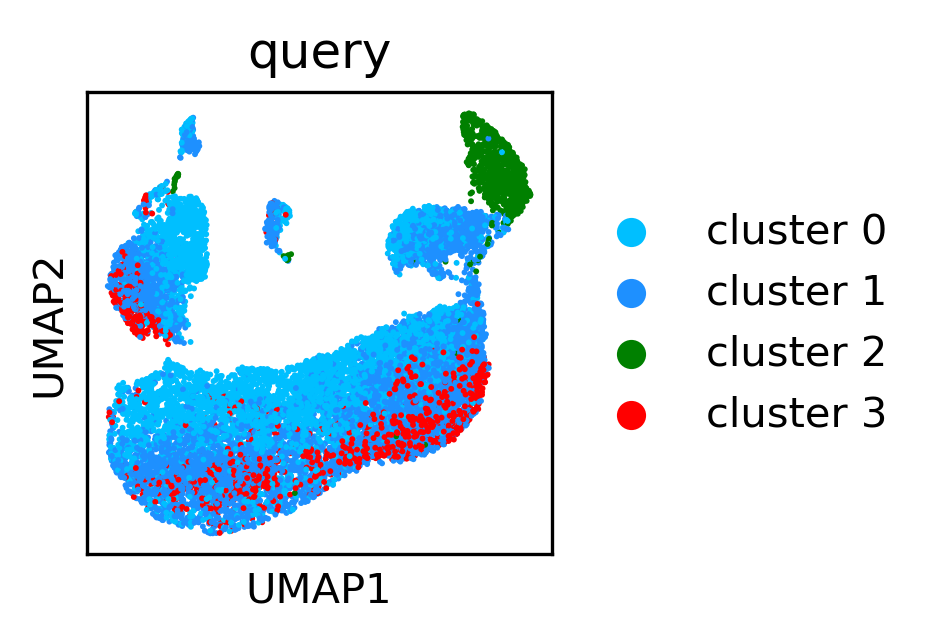

In [10]:
sc.pp.neighbors(q)
sc.tl.umap(q)

# rename labels for the plots 
q.obs['query'] = q.obs['labels'].astype('str')
q.obs.loc[q.obs['labels'] == 'CD4+ T cell', 'query'] = 'cluster 0'
q.obs.loc[q.obs['labels'] == 'Cytotoxic T cell', 'query'] = 'cluster 1'
q.obs.loc[q.obs['labels'] == 'Megakaryocyte', 'query'] = 'cluster 2'
q.obs.loc[q.obs['labels'] == 'Natural killer cell', 'query'] = 'cluster 3'

q_palette = {"cluster 0": 'deepskyblue', "cluster 1": 'dodgerblue', 'cluster 2': 'green', 'cluster 3': 'red'}

with plt.rc_context({'figure.figsize': (2, 2), 'figure.dpi': (300)}):
    sc.pl.umap(q, color='query', palette=q_palette)


... storing 'reference' as categorical


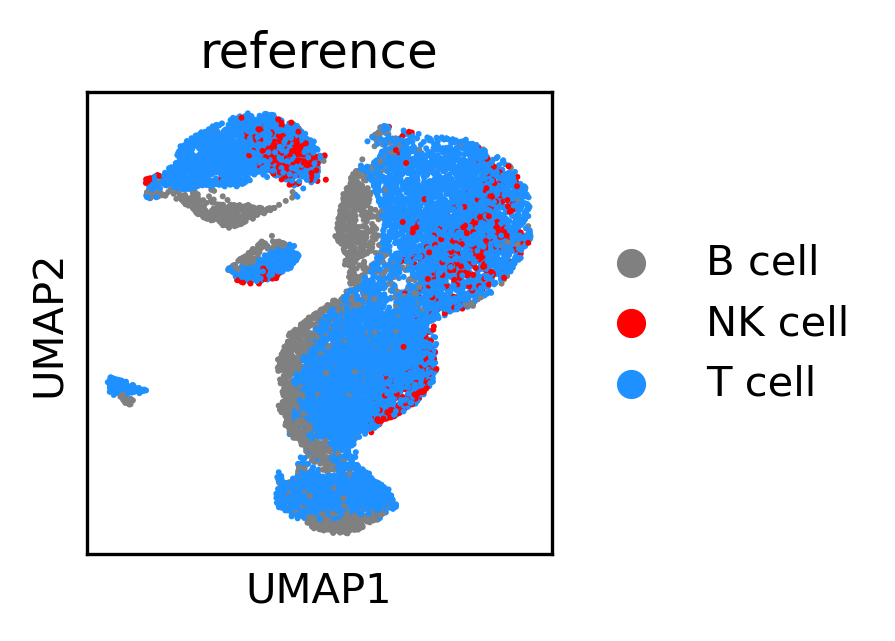

In [11]:
sc.pp.neighbors(ref)
sc.tl.umap(ref)

# rename labels for the plots 
ref.obs['reference'] = ref.obs['labels'].astype('str')
ref.obs.loc[ref.obs['labels'] == 'Natural killer cell', 'reference'] = 'NK cell'

ref_palette = {"B cell": 'gray', "T cell": 'dodgerblue', 'NK cell': 'red'}

with plt.rc_context({'figure.figsize': (2, 2), 'figure.dpi': (300)}):
    sc.pl.umap(ref, color='reference', palette=ref_palette)


We can retrieve the underlying hvg embedding performed before the OT step as follows:

In [12]:
from embeddings import HVGEmbedder

hvg = HVGEmbedder(max_cluster_size=None)
hvg.fit(q, ref)

q_embed = hvg.embed(q)
ref_embed = hvg.embed(ref)

[embeddings      ] [DEBUG   ] : Using 1478 genes.


In [15]:
# create a new anndata object for joint umap
X = np.concatenate((q_embed, ref_embed), axis=0)
obs = pd.concat((q.obs['query'], ref.obs['reference']), axis=0)
obs = obs.to_frame(name='labels')

ad = sc.AnnData(X, obs)

/opt/homebrew/anaconda3/envs/refcm/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



/opt/homebrew/anaconda3/envs/refcm/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

... storing 'labels' as categorical
... storing 'query' as categorical
... storing 'reference' as categorical


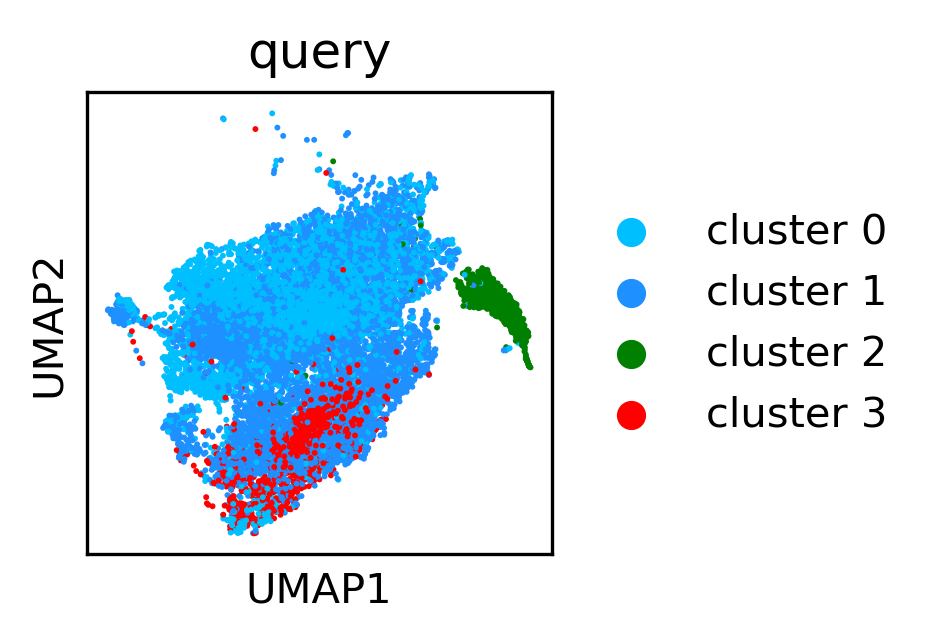

/opt/homebrew/anaconda3/envs/refcm/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

... storing 'labels' as categorical
... storing 'query' as categorical
... storing 'reference' as categorical


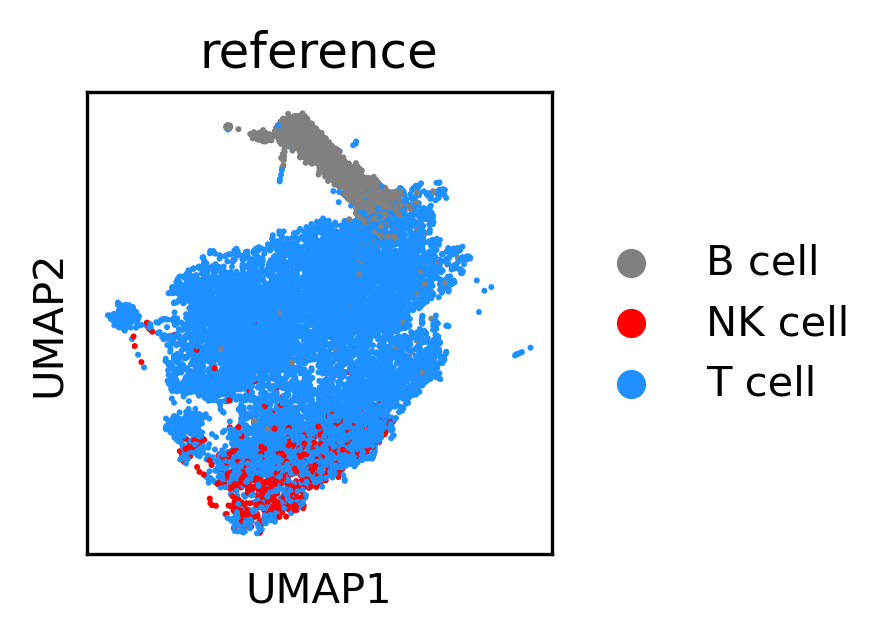

In [17]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

# rename labels for the plots
ad.obs['query'] = ad.obs['labels'].astype('str')
ad.obs['reference'] = ad.obs['labels'].astype('str')

with plt.rc_context({'figure.figsize': (2, 2), 'figure.dpi': (300)}):
    sc.pl.umap(ad[:q_embed.shape[0]].copy(), color='query', palette=q_palette)
    sc.pl.umap(ad[q_embed.shape[0]:].copy(), color='reference', palette=ref_palette)
